# GemPy Pipeline Debug Notebook

This notebook steps through the DSL → GemPy model pipeline to debug rendering issues.

In [1]:
# Add project root to path
import sys

sys.path.insert(0, "..")

## Step 1: Define the DSL

In [2]:
DSL_TEXT = """
ROCK R1 [ name: "basanite"; type: volcanic ]
ROCK R2 [ name: "rhyolite"; type: volcanic ]
ROCK R3 [ name: "monzonite"; type: intrusive ]
ROCK R4 [ name: "latite"; type: volcanic ]
ROCK R5 [ name: "quartz latite"; type: volcanic ]
DEPOSITION D1 [ rock: R1 ]
DEPOSITION D2 [ rock: R2; after: D1 ]
INTRUSION I1 [ rock: R3; style: stock ]
INTRUSION I2 [ rock: R4; style: dike; after: I1 ]
INTRUSION I3 [ rock: R5; style: dike; after: I1 ]
"""

print(DSL_TEXT)


ROCK R1 [ name: "basanite"; type: volcanic ]
ROCK R2 [ name: "rhyolite"; type: volcanic ]
ROCK R3 [ name: "monzonite"; type: intrusive ]
ROCK R4 [ name: "latite"; type: volcanic ]
ROCK R5 [ name: "quartz latite"; type: volcanic ]
DEPOSITION D1 [ rock: R1 ]
DEPOSITION D2 [ rock: R2; after: D1 ]
INTRUSION I1 [ rock: R3; style: stock ]
INTRUSION I2 [ rock: R4; style: dike; after: I1 ]
INTRUSION I3 [ rock: R5; style: dike; after: I1 ]



## Step 2: Parse and Validate DSL

In [3]:
from geo_lm.parsers.dsl import parse_and_validate

program, validation_result = parse_and_validate(DSL_TEXT)

print(f"Is Valid: {validation_result.is_valid}")
print(f"Errors: {validation_result.errors}")
print(f"\nProgram type: {type(program)}")

Is Valid: True
Errors: []

Program type: <class 'geo_lm.parsers.dsl.ast.Program'>


In [4]:
# Inspect the parsed program
print("=== ROCKS ===")
for rock in program.rocks:
    print(f"  {rock.id}: {rock.name} ({rock.rock_type})")

print("\n=== DEPOSITIONS ===")
for dep in program.depositions:
    print(f"  {dep.id}: rock={dep.rock_id}, after={list(dep.after)}")

print("\n=== INTRUSIONS ===")
for intr in program.intrusions:
    print(
        f"  {intr.id}: rock={intr.rock_id}, style={intr.style}, after={list(intr.after)}"
    )

print("\n=== EROSIONS ===")
for ero in program.erosions:
    print(f"  {ero.id}: after={list(ero.after)}")

print("\n=== ALL EVENTS (via all_events property) ===")
for event in program.all_events:
    print(f"  {event.id}: {type(event).__name__}")

=== ROCKS ===
  R1: "basanite" (RockType.VOLCANIC)
  R2: "rhyolite" (RockType.VOLCANIC)
  R3: "monzonite" (RockType.INTRUSIVE)
  R4: "latite" (RockType.VOLCANIC)
  R5: "quartz latite" (RockType.VOLCANIC)

=== DEPOSITIONS ===
  D1: rock=R1, after=[]
  D2: rock=R2, after=['D1']

=== INTRUSIONS ===
  I1: rock=R3, style=IntrusionStyle.STOCK, after=[]
  I2: rock=R4, style=IntrusionStyle.DIKE, after=['I1']
  I3: rock=R5, style=IntrusionStyle.DIKE, after=['I1']

=== EROSIONS ===

=== ALL EVENTS (via all_events property) ===
  D1: DepositionEvent
  D2: DepositionEvent
  I1: IntrusionEvent
  I2: IntrusionEvent
  I3: IntrusionEvent


## Step 3: Transform DSL to GemPy Configuration

In [5]:
from geo_lm.gempy.transformer import DSLToGemPyTransformer

transformer = DSLToGemPyTransformer()
config = transformer.transform(program, name="DebugModel")

print(f"Model name: {config.name}")
print(f"Number of surfaces: {len(config.surfaces)}")
print(f"Number of structural groups: {len(config.structural_groups)}")

Model name: DebugModel
Number of surfaces: 5
Number of structural groups: 4


In [6]:
# Inspect surfaces
print("=== SURFACES ===")
for s in config.surfaces:
    print(f"  {s.surface_id}: {s.name} (rock_type={s.rock_type})")

=== SURFACES ===
  D1: "basanite" (rock_type=volcanic)
  D2: "rhyolite" (rock_type=volcanic)
  I1: "monzonite" (rock_type=intrusive)
  I2: "latite" (rock_type=volcanic)
  I3: "quartz latite" (rock_type=volcanic)


In [7]:
# Inspect structural groups
print("=== STRUCTURAL GROUPS ===")
for g in config.structural_groups:
    print(f"  Group {g.group_index}: {g.group_name}")
    print(f"    Relation: {g.relation}")
    print(f"    Surfaces: {g.surfaces}")

=== STRUCTURAL GROUPS ===
  Group 0: Intrusion_R5
    Relation: GemPyRelationType.ERODE
    Surfaces: ['I3']
  Group 1: Intrusion_R4
    Relation: GemPyRelationType.ERODE
    Surfaces: ['I2']
  Group 2: Intrusion_R3
    Relation: GemPyRelationType.ERODE
    Surfaces: ['I1']
  Group 3: Strata_Group_0
    Relation: GemPyRelationType.BASEMENT
    Surfaces: ['D1', 'D2']


In [8]:
# Inspect event order
print("=== EVENT ORDER (oldest first) ===")
print(config.event_order)

=== EVENT ORDER (oldest first) ===
['D1', 'D2', 'I1', 'I2', 'I3']


In [9]:
# Inspect extent
print("=== MODEL EXTENT ===")
print(f"  X: {config.extent.x_min} to {config.extent.x_max}")
print(f"  Y: {config.extent.y_min} to {config.extent.y_max}")
print(f"  Z: {config.extent.z_min} to {config.extent.z_max}")

=== MODEL EXTENT ===
  X: -500.0 to 500.0
  Y: -500.0 to 500.0
  Z: -1000.0 to 0.0


## Step 4: Validate GemPy Configuration

In [10]:
from geo_lm.gempy.validator import GemPyConfigValidator

config_validator = GemPyConfigValidator()
config_result = config_validator.validate(config)

print(f"Config Valid: {config_result.is_valid}")
print(f"Errors: {config_result.errors}")
print(f"Warnings: {config_result.warnings}")

Config Valid: True
Errors: []
Warnings: []


## Step 5: Generate Spatial Data (Points & Orientations)

In [11]:
from geo_lm.gempy.spatial import RuleBasedSpatialGenerator

generator = RuleBasedSpatialGenerator(seed=42)
model_data = generator.generate(config)

print(f"Surface points: {len(model_data.surface_points)}")
print(f"Orientations: {len(model_data.orientations)}")

Surface points: 50
Orientations: 4


In [12]:
# Inspect surface points by surface
from collections import Counter

point_counts = Counter(p.surface for p in model_data.surface_points)
print("=== POINTS PER SURFACE ===")
for surface_id, count in point_counts.items():
    print(f"  {surface_id}: {count} points")

=== POINTS PER SURFACE ===
  D1: 10 points
  D2: 10 points
  I1: 10 points
  I2: 10 points
  I3: 10 points


In [13]:
# Inspect some surface points
print("=== SAMPLE SURFACE POINTS ===")
for p in model_data.surface_points[:5]:
    print(f"  {p.surface}: ({p.x:.1f}, {p.y:.1f}, {p.z:.1f})")

=== SAMPLE SURFACE POINTS ===
  D1: (-180.0, -221.4, -909.5)
  D1: (313.7, -330.4, -834.2)
  D1: (-62.5, -376.2, -877.8)
  D1: (-378.8, -240.9, -931.0)
  D1: (119.9, 36.0, -883.9)


In [14]:
# Inspect orientations
print("=== ORIENTATIONS ===")
for o in model_data.orientations:
    print(
        f"  {o.surface}: pos=({o.x:.1f}, {o.y:.1f}, {o.z:.1f}), dip={o.dip:.1f}°, azimuth={o.azimuth:.1f}°"
    )

=== ORIENTATIONS ===
  D1: pos=(0.0, 0.0, -900.0), dip=9.6°, azimuth=331.5°
  I1: pos=(0.0, 0.0, -500.0), dip=39.5°, azimuth=279.4°
  I2: pos=(0.0, 0.0, -300.0), dip=14.9°, azimuth=1.7°
  I3: pos=(0.0, 0.0, -100.0), dip=13.2°, azimuth=19.9°


In [15]:
# Check updated extent after spatial generation
print("=== UPDATED MODEL EXTENT ===")
print(f"  X: {model_data.config.extent.x_min} to {model_data.config.extent.x_max}")
print(f"  Y: {model_data.config.extent.y_min} to {model_data.config.extent.y_max}")
print(f"  Z: {model_data.config.extent.z_min} to {model_data.config.extent.z_max}")

=== UPDATED MODEL EXTENT ===
  X: -500.0 to 500.0
  Y: -500.0 to 500.0
  Z: -1016.4300000000001 to 8.610000000000014


## Step 6: Validate Complete Model Data

In [16]:
from geo_lm.gempy.validator import GemPyDataValidator

data_validator = GemPyDataValidator()
data_result = data_validator.validate(model_data)

print(f"Data Valid: {data_result.is_valid}")
print(f"Errors: {data_result.errors}")
print(f"Warnings: {data_result.warnings}")

Data Valid: True
Errors: []
Warnings: []


## Step 7: Build GemPy Model

In [17]:
from geo_lm.gempy.builder import GemPyModelBuilder

builder = GemPyModelBuilder()
geo_model = builder.build(model_data)

print(f"GeoModel created: {geo_model.meta.name}")
print(f"Extent: {geo_model.grid.extent}")
print(f"Resolution: {geo_model.grid.regular_grid.resolution}")

Setting Backend To: AvailableBackends.numpy
GeoModel created: DebugModel
Extent: [ -500.     500.    -500.     500.   -1016.43     8.61]
Resolution: [50 50 50]


In [18]:
# Inspect structural frame
print("=== STRUCTURAL FRAME ===")
for group in geo_model.structural_frame.structural_groups:
    print(f"  Group: {group.name}")
    print(f"    Relation: {group.structural_relation}")
    for element in group.elements:
        print(f"    - Element: {element.name}")

=== STRUCTURAL FRAME ===
  Group: Intrusion_R5
    Relation: StackRelationType.ERODE
    - Element: I3
  Group: Intrusion_R4
    Relation: StackRelationType.ERODE
    - Element: I2
  Group: Intrusion_R3
    Relation: StackRelationType.ERODE
    - Element: I1
  Group: Strata_Group_0
    Relation: StackRelationType.BASEMENT
    - Element: D1
    - Element: D2


In [19]:
# Inspect surface points in GemPy model
print("=== SURFACE POINTS IN GEMPY ===")
print(geo_model.surface_points_copy.df)

=== SURFACE POINTS IN GEMPY ===
         X       Y       Z         id   nugget
0  -153.99 -353.66 -153.37  464914859  0.00002
1  -331.48  -11.21 -182.29  464914859  0.00002
2  -344.63  208.48 -159.01  464914859  0.00002
3   -19.77   39.84 -103.79  464914859  0.00002
4  -187.95  297.95 -120.69  464914859  0.00002
5    31.44  183.94  -76.81  464914859  0.00002
6  -239.08 -150.63 -157.41  464914859  0.00002
7   -49.52   14.06 -110.00  464914859  0.00002
8  -303.20 -220.24 -187.83  464914859  0.00002
9  -215.91 -223.83 -159.72  464914859  0.00002
10  376.86  288.62 -189.16  328052319  0.00002
11  145.37   29.58 -260.41  328052319  0.00002
12 -186.54  112.77 -344.76  328052319  0.00002
13  -37.02  363.05 -303.48  328052319  0.00002
14  300.68 -189.29 -224.47  328052319  0.00002
15  330.10  296.41 -209.55  328052319  0.00002
16 -161.24  111.16 -344.34  328052319  0.00002
17  210.01   31.50 -245.55  328052319  0.00002
18  222.90   24.28 -235.92  328052319  0.00002
19 -384.42  343.28 -399.73  

In [20]:
# Inspect orientations in GemPy model
print("=== ORIENTATIONS IN GEMPY ===")
print(geo_model.orientations_copy.df)

=== ORIENTATIONS IN GEMPY ===
     X    Y      Z       G_x       G_y       G_z         id  nugget
0  0.0  0.0 -100.0  0.077726  0.214716  0.973579  464914859    0.01
1  0.0  0.0 -300.0  0.007628  0.257020  0.966376  328052319    0.01
2  0.0  0.0 -500.0 -0.627537  0.103888  0.771625  204906139    0.01
3  0.0  0.0 -900.0 -0.079575  0.146559  0.985996   67498830    0.01


## Step 8: Compute the Model

In [21]:
import gempy as gp
from gempy.core.data.grid import Grid

# Check grid state
print("=== GRID STATE ===")
print(f"Active grids: {geo_model.grid.active_grids}")
print(f"Regular grid resolution: {geo_model.grid.regular_grid.resolution}")

# Set DENSE grid active (this is the regular/dense grid for visualization)
gp.set_active_grid(geo_model.grid, grid_type=[Grid.GridTypes.DENSE])
print(f"Active grids after: {geo_model.grid.active_grids}")

# Compute the model
print("\n=== COMPUTING MODEL ===")
gp.compute_model(geo_model)

print("\nModel computed!")
print(f"Solutions is not None: {geo_model.solutions is not None}")

=== GRID STATE ===
Active grids: GridTypes.DENSE|NONE
Regular grid resolution: [50 50 50]
Active grids: GridTypes.DENSE|NONE
Active grids after: GridTypes.DENSE|NONE

=== COMPUTING MODEL ===
Setting Backend To: AvailableBackends.numpy
Chunking done: 7 chunks
Chunking done: 7 chunks
Chunking done: 7 chunks
Chunking done: 7 chunks
Chunking done: 12 chunks
Chunking done: 7 chunks
Chunking done: 7 chunks
Chunking done: 7 chunks
Chunking done: 11 chunks

Model computed!
Solutions is not None: True


In [22]:
# Check what's in solutions after compute
print("=== SOLUTIONS STATE ===")

if geo_model.solutions is None:
    print("ERROR: geo_model.solutions is None!")
    print("The model may not have computed successfully.")
    print("\nTrying to compute again...")
    gp.compute_model(geo_model)
    print(f"After retry - solutions is None: {geo_model.solutions is None}")

if geo_model.solutions is not None:
    print(f"solutions type: {type(geo_model.solutions)}")
    sol_attrs = [a for a in dir(geo_model.solutions) if not a.startswith("_")]
    print(f"solutions attributes: {sol_attrs}")

    if (
        hasattr(geo_model.solutions, "raw_arrays")
        and geo_model.solutions.raw_arrays is not None
    ):
        ra = geo_model.solutions.raw_arrays
        print(f"\nraw_arrays type: {type(ra)}")
        attrs = [a for a in dir(ra) if not a.startswith("_")]
        print(f"raw_arrays attributes: {attrs}")

        # Check key attributes
        for attr in ["lith_block", "scalar_field_matrix", "n_surfaces", "block_matrix"]:
            if hasattr(ra, attr):
                val = getattr(ra, attr)
                if hasattr(val, "shape"):
                    print(f"  {attr}: shape={val.shape}")
                else:
                    print(f"  {attr}: {val}")
            else:
                print(f"  {attr}: NOT PRESENT")
    else:
        print("raw_arrays is None or not present!")

    if hasattr(geo_model.solutions, "dc_meshes"):
        print(f"\ndc_meshes: {geo_model.solutions.dc_meshes}")
    if hasattr(geo_model.solutions, "block_solution_type"):
        print(f"block_solution_type: {geo_model.solutions.block_solution_type}")

=== SOLUTIONS STATE ===
solutions type: <class 'gempy_engine.core.data.solutions.Solutions'>
solutions attributes: ['block_solution_resolution', 'block_solution_type', 'dc_meshes', 'debug_input_data', 'gravity', 'magnetics', 'meshes_to_unstruct', 'octrees_output', 'raw_arrays', 'scalar_field_at_surface_points']

raw_arrays type: <class 'gempy_engine.core.data.raw_arrays_solution.RawArraysSolution'>
raw_arrays attributes: ['BlockSolutionType', 'block_matrix', 'custom', 'dense_ids', 'edges', 'fault_block', 'from_gempy_engine_solutions', 'fw_gravity', 'fw_magnetic', 'geological_map', 'gradient', 'lith_block', 'litho_faults_block', 'mask_matrix', 'mask_matrix_squeezed', 'meshes_to_subsurface', 'scalar_field_at_surface_points', 'scalar_field_matrix', 'sections', 'topology_count', 'topology_edges', 'values_matrix', 'vertices']
  lith_block: shape=(125000,)
  scalar_field_matrix: shape=(4, 125000)
  n_surfaces: NOT PRESENT
  block_matrix: shape=(4, 125000)

dc_meshes: [DualContouringMesh(318 

## Step 9: Extract Meshes

In [23]:
# Check if meshes are available in solutions after compute
# (marching cubes may run automatically depending on GemPy version/settings)

print("=== CHECKING FOR MESHES ===")
print(f"dc_meshes: {geo_model.solutions.dc_meshes}")

# Check structural elements for mesh data (alternative location)
print("\n=== STRUCTURAL ELEMENT MESHES ===")
for group in geo_model.structural_frame.structural_groups:
    for element in group.elements:
        v = element.vertices
        e = element.edges
        has_mesh = v is not None and len(v) > 0 if v is not None else False
        print(f"  {element.name}: has_mesh={has_mesh}")
        if has_mesh:
            print(f"    vertices: {v.shape}")
            print(f"    edges: {e.shape}")

=== CHECKING FOR MESHES ===
dc_meshes: [DualContouringMesh(318 vertices, 566 edges), DualContouringMesh(324 vertices, 580 edges), DualContouringMesh(460 vertices, 843 edges), DualContouringMesh(311 vertices, 560 edges), DualContouringMesh(235 vertices, 405 edges)]

=== STRUCTURAL ELEMENT MESHES ===
  I3: has_mesh=True
    vertices: (318, 3)
    edges: (566, 3)
  I2: has_mesh=True
    vertices: (324, 3)
    edges: (580, 3)
  I1: has_mesh=True
    vertices: (460, 3)
    edges: (843, 3)
  D2: has_mesh=True
    vertices: (235, 3)
    edges: (405, 3)
  D1: has_mesh=True
    vertices: (311, 3)
    edges: (560, 3)


In [ ]:
# Inspect actual mesh data from structural elements
import numpy as np

print("=== MESH DATA INSPECTION ===\n")

# Get our model extent for comparison
extent = model_data.config.extent
print(f"Model extent:")
print(f"  X: {extent.x_min} to {extent.x_max}")
print(f"  Y: {extent.y_min} to {extent.y_max}")
print(f"  Z: {extent.z_min} to {extent.z_max}")

print("\n=== MESH VERTICES (raw from structural elements) ===")
for group in geo_model.structural_frame.structural_groups:
    for element in group.elements:
        if element.vertices is not None and len(element.vertices) > 0:
            v = element.vertices
            print(f"\n{element.name}:")
            print(f"  Vertices shape: {v.shape}")
            print(f"  X range: {v[:, 0].min():.2f} to {v[:, 0].max():.2f}")
            print(f"  Y range: {v[:, 1].min():.2f} to {v[:, 1].max():.2f}")
            print(f"  Z range: {v[:, 2].min():.2f} to {v[:, 2].max():.2f}")
            print(f"  First 3 vertices:\n{v[:3]}")

print("\n=== INPUT TRANSFORM ===")
print(f"Transform object: {geo_model.input_transform}")
print(f"Transform type: {type(geo_model.input_transform)}")
if hasattr(geo_model.input_transform, "scale"):
    print(f"Scale: {geo_model.input_transform.scale}")
if hasattr(geo_model.input_transform, "translation"):
    print(f"Translation: {geo_model.input_transform.translation}")

=== MESH DATA INSPECTION ===

Model extent:
  X: -500.0 to 500.0
  Y: -500.0 to 500.0
  Z: -1016.4300000000001 to 8.610000000000014

=== MESH VERTICES (raw from structural elements) ===

I3:
  Vertices shape: (318, 3)
  X range: -497.97 to 493.93
  Y range: -468.82 to 473.65
  Z range: -269.02 to 7.45
  First 3 vertices:
[[-468.7097662  -468.73452933 -269.02060504]
 [-468.70269826 -406.23159291 -262.17282738]
 [-418.93428869 -468.74219692 -253.55174634]]

I2:
  Vertices shape: (324, 3)
  X range: -496.36 to 497.54
  Y range: -468.75 to 497.21
  Z range: -418.24 to -115.46
  First 3 vertices:
[[-469.70944153 -344.38531659 -251.94506419]
 [-468.81559974 -281.15235809 -263.333771  ]
 [-421.79412333 -324.06704625 -249.41734565]]

I1:
  Vertices shape: (460, 3)
  X range: -468.75 to 499.92
  Y range: -401.51 to 488.89
  Z range: -1011.53 to -224.19
  First 3 vertices:
[[-468.75268909  -29.65437781 -528.80489542]
 [-406.24915243  -30.44320484 -529.37610744]
 [-337.47438111  -37.61016752 -524

In [ ]:
# Try applying inverse transform to get world coordinates
print("=== TESTING INVERSE TRANSFORM ===\n")

# Get first element with mesh
test_element = None
for group in geo_model.structural_frame.structural_groups:
    for element in group.elements:
        if element.vertices is not None and len(element.vertices) > 0:
            test_element = element
            break
    if test_element:
        break

if test_element:
    raw_vertices = test_element.vertices
    print(f"Testing with element: {test_element.name}")
    print(f"Raw vertices (first 3):\n{raw_vertices[:3]}")

    # Try inverse transform
    if hasattr(geo_model.input_transform, "apply_inverse"):
        try:
            transformed = geo_model.input_transform.apply_inverse(raw_vertices)
            print(f"\nAfter apply_inverse (first 3):\n{transformed[:3]}")
            print(f"\nTransformed ranges:")
            print(
                f"  X: {transformed[:, 0].min():.2f} to {transformed[:, 0].max():.2f}"
            )
            print(
                f"  Y: {transformed[:, 1].min():.2f} to {transformed[:, 1].max():.2f}"
            )
            print(
                f"  Z: {transformed[:, 2].min():.2f} to {transformed[:, 2].max():.2f}"
            )
        except Exception as e:
            print(f"apply_inverse failed: {e}")
    else:
        print("No apply_inverse method available")

    # Compare with our surface points
    print(f"\n=== COMPARISON WITH OUR SURFACE POINTS ===")
    our_points = [
        p for p in model_data.surface_points if p.surface == test_element.name
    ]
    if our_points:
        print(f"Our points for {test_element.name} (first 3):")
        for p in our_points[:3]:
            print(f"  ({p.x:.2f}, {p.y:.2f}, {p.z:.2f})")
    else:
        print(f"No points found for surface '{test_element.name}'")

=== TESTING INVERSE TRANSFORM ===

Testing with element: I3
Raw vertices (first 3):
[[-468.7097662  -468.73452933 -269.02060504]
 [-468.70269826 -406.23159291 -262.17282738]
 [-418.93428869 -468.74219692 -253.55174634]]

After apply_inverse (first 3):
[[-800747.54456766 -800801.94490875 -460098.71165085]
 [-800735.46970857 -694021.92832602 -448399.96829243]
 [-715711.11879786 -800815.04421079 -433671.71344096]]

Transformed ranges:
  X: -850733.29 to 843822.76
  Y: -800955.83 to 809164.67
  Z: -460098.71 to 12225.73

=== COMPARISON WITH OUR SURFACE POINTS ===
Our points for I3 (first 3):
  (-153.99, -353.66, -153.37)
  (-331.48, -11.21, -182.29)
  (-344.63, 208.48, -159.01)


## Step 10: Visualize with GemPy Viewer

In [26]:
# Debug: Check versions and solutions state before plotting
import gempy as gp
import gempy_viewer as gpv

print("=== VERSION INFO ===")
print(f"GemPy version: {gp.__version__}")
print(f"gempy_viewer version: {gpv.__version__}")

print("\n=== SOLUTIONS STATE ===")
print(f"solutions type: {type(geo_model.solutions)}")
print(f"solutions.raw_arrays: {geo_model.solutions.raw_arrays}")

if geo_model.solutions.raw_arrays is not None:
    ra = geo_model.solutions.raw_arrays
    print(f"\nraw_arrays attributes: {[a for a in dir(ra) if not a.startswith('_')]}")
    if hasattr(ra, "lith_block"):
        print(
            f"lith_block shape: {ra.lith_block.shape if ra.lith_block is not None else None}"
        )
    if hasattr(ra, "n_surfaces"):
        print(f"n_surfaces: {ra.n_surfaces}")
    else:
        print("n_surfaces: NOT PRESENT")

print("\n=== GRID INFO ===")
print(f"Grid types active: {geo_model.grid.active_grids}")
print(f"Regular grid resolution: {geo_model.grid.regular_grid.resolution}")

print("\n=== STRUCTURAL FRAME ===")
print(f"Number of elements: {len(geo_model.structural_frame.structural_elements)}")
for elem in geo_model.structural_frame.structural_elements:
    print(f"  - {elem.name}")

=== VERSION INFO ===
GemPy version: 2024.2.0.2
gempy_viewer version: 2025.1.6

=== SOLUTIONS STATE ===
solutions type: <class 'gempy_engine.core.data.solutions.Solutions'>
solutions.raw_arrays: RawArraysSolution(lith_block=array([6, 6, 6, ..., 2, 2, 2], shape=(125000,), dtype=int8), fault_block=array([0, 0, 0, ..., 0, 0, 0], shape=(125000,), dtype=int8), litho_faults_block=array([6, 6, 6, ..., 2, 2, 2], shape=(125000,), dtype=int32), scalar_field_matrix=array([[-0.35829292, -0.33751347, -0.31674177, ...,  0.30883219,
         0.33051474,  0.35221492],
       [-0.45440593, -0.43794034, -0.42139419, ...,  0.28305767,
         0.29661453,  0.31021736],
       [-0.70948143, -0.69591964, -0.68232177, ...,  0.53120248,
         0.54587585,  0.56060506],
       [-0.35641896, -0.33508229, -0.31398248, ...,  0.37829669,
         0.39439048,  0.41057324]], shape=(4, 125000)), block_matrix=array([[2., 2., 2., ..., 2., 2., 2.],
       [3., 3., 3., ..., 2., 2., 2.],
       [4., 4., 4., ..., 3., 3.,

In [27]:
# Try plotting - start with simpler options
import gempy_viewer as gpv

# First try just plotting data points (no surfaces)
print("Trying plot_3d with show_surfaces=False...")
gpv.plot_3d(geo_model, show_surfaces=False, show_data=True)

Trying plot_3d with show_surfaces=False...


AttributeError: 'RawArraysSolution' object has no attribute 'n_surfaces'


Trying plot_2d...


/Users/williamdavis/Documents/Prototypes/geo-lm/.venv/lib/python3.12/site-packages/gempy_viewer/API/_plot_2d_API.py:176: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


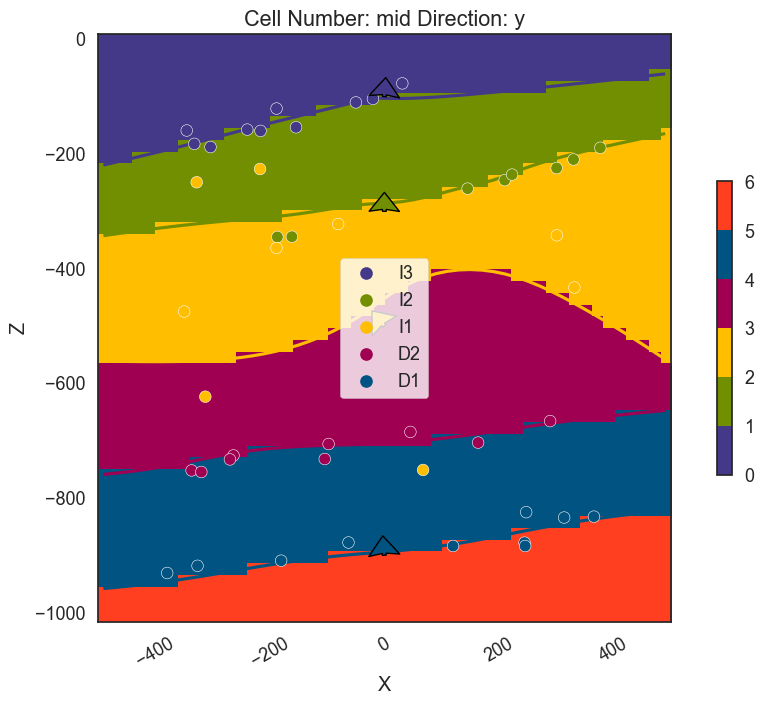

In [28]:
# Then try 2D which is usually more stable
print("\nTrying plot_2d...")
gpv.plot_2d(geo_model, show_data=True)

# Step 11: Mesh Export

In [ ]:
# Test CORRECTED mesh export (no inverse transform)
print("=== CORRECTED MESH EXPORT TEST ===\n")

# Rock type to color mapping
ROCK_TYPE_COLORS = {
    "sedimentary": "#D2B48C",
    "volcanic": "#2F4F4F",
    "intrusive": "#808080",
    "metamorphic": "#696969",
}

# Build surface config lookup
surface_config_map = {s.surface_id: s for s in model_data.config.surfaces}

exported_surfaces = []

for group in geo_model.structural_frame.structural_groups:
    for element in group.elements:
        if element.vertices is not None and len(element.vertices) > 0:
            element_name = element.name
            config = surface_config_map.get(element_name)

            # Use raw vertices directly - NO inverse transform!
            vertices = element.vertices
            faces = element.edges

            # Get color
            if config and config.rock_type in ROCK_TYPE_COLORS:
                color = ROCK_TYPE_COLORS[config.rock_type]
            else:
                color = "#888888"

            exported_surfaces.append(
                {
                    "name": config.name if config else element_name,
                    "surface_id": element_name,
                    "color": color,
                    "vertices": vertices.tolist(),
                    "faces": faces.tolist(),
                }
            )

            print(f"{element_name}:")
            print(f"  Name: {config.name if config else 'N/A'}")
            print(f"  Color: {color}")
            print(f"  Vertices: {len(vertices)} points")
            print(f"  Faces: {len(faces)} triangles")
            print(
                f"  X range: {vertices[:, 0].min():.1f} to {vertices[:, 0].max():.1f}"
            )
            print(
                f"  Y range: {vertices[:, 1].min():.1f} to {vertices[:, 1].max():.1f}"
            )
            print(
                f"  Z range: {vertices[:, 2].min():.1f} to {vertices[:, 2].max():.1f}"
            )
            print()

print(f"\nTotal surfaces exported: {len(exported_surfaces)}")

=== CORRECTED MESH EXPORT TEST ===

I3:
  Name: "quartz latite"
  Color: #2F4F4F
  Vertices: 318 points
  Faces: 566 triangles
  X range: -498.0 to 493.9
  Y range: -468.8 to 473.6
  Z range: -269.0 to 7.5

I2:
  Name: "latite"
  Color: #2F4F4F
  Vertices: 324 points
  Faces: 580 triangles
  X range: -496.4 to 497.5
  Y range: -468.7 to 497.2
  Z range: -418.2 to -115.5

I1:
  Name: "monzonite"
  Color: #808080
  Vertices: 460 points
  Faces: 843 triangles
  X range: -468.8 to 499.9
  Y range: -401.5 to 488.9
  Z range: -1011.5 to -224.2

D2:
  Name: "rhyolite"
  Color: #2F4F4F
  Vertices: 235 points
  Faces: 405 triangles
  X range: -500.0 to 468.9
  Y range: -495.3 to 337.5
  Z range: -760.1 to -646.8

D1:
  Name: "basanite"
  Color: #2F4F4F
  Vertices: 311 points
  Faces: 560 triangles
  X range: -492.5 to 488.2
  Y range: -498.9 to 500.0
  Z range: -976.5 to -797.5


Total surfaces exported: 5


In [30]:
# Verify the exported data structure matches what frontend expects
import json

print("=== SAMPLE JSON OUTPUT ===\n")

# Create the full mesh response structure
mesh_response = {
    "model_id": 1,
    "name": model_data.config.name,
    "surfaces": exported_surfaces,
    "extent": {
        "x_min": model_data.config.extent.x_min,
        "x_max": model_data.config.extent.x_max,
        "y_min": model_data.config.extent.y_min,
        "y_max": model_data.config.extent.y_max,
        "z_min": model_data.config.extent.z_min,
        "z_max": model_data.config.extent.z_max,
    },
}

# Print summary (not full JSON - too large)
print(f"Model name: {mesh_response['name']}")
print(f"Extent: {mesh_response['extent']}")
print(f"Number of surfaces: {len(mesh_response['surfaces'])}")
print()

# Show first surface details (truncated)
if exported_surfaces:
    s = exported_surfaces[0]
    print(f"First surface sample:")
    print(f"  surface_id: {s['surface_id']}")
    print(f"  name: {s['name']}")
    print(f"  color: {s['color']}")
    print(f"  vertices count: {len(s['vertices'])}")
    print(f"  faces count: {len(s['faces'])}")
    print(f"  first 3 vertices: {s['vertices'][:3]}")
    print(f"  first 3 faces: {s['faces'][:3]}")

=== SAMPLE JSON OUTPUT ===

Model name: DebugModel
Extent: {'x_min': -500.0, 'x_max': 500.0, 'y_min': -500.0, 'y_max': 500.0, 'z_min': -1016.4300000000001, 'z_max': 8.610000000000014}
Number of surfaces: 5

First surface sample:
  surface_id: I3
  name: "quartz latite"
  color: #2F4F4F
  vertices count: 318
  faces count: 566
  first 3 vertices: [[-468.709766195073, -468.73452933080404, -269.02060504029873], [-468.7026982606914, -406.23159290916544, -262.17282737791356], [-418.93428868991845, -468.74219691570465, -253.55174633631304]]
  first 3 faces: [[8, 3, 7], [10, 5, 9], [11, 6, 8]]


In [ ]:
# Try point cloud fallback
exporter_fallback = MeshExporter(use_point_cloud_fallback=True)
mesh_data_fallback = exporter_fallback.export_from_data(
    model_id=1, data=model_data, compute_meshes=False
)

print(f"Point cloud export:")
print(f"Number of surfaces: {len(mesh_data_fallback.surfaces)}")
for s in mesh_data_fallback.surfaces:
    print(f"  {s.surface_id}: {len(s.vertices)} vertices, {len(s.faces)} faces")

## Step 12: Debug - Manual Mesh Check

In [ ]:
# Manually inspect mesh data from first element with vertices
for group in geo_model.structural_frame.structural_groups:
    for element in group.elements:
        if element.vertices is not None and len(element.vertices) > 0:
            print(f"\n=== {element.name} ===")
            print(f"Vertices shape: {element.vertices.shape}")
            print(f"Vertices sample (first 5):")
            print(element.vertices[:5])
            print(f"\nEdges shape: {element.edges.shape}")
            print(f"Edges sample (first 5):")
            print(element.edges[:5])
            break
    else:
        continue
    break

In [ ]:
# Check input transform
print("=== INPUT TRANSFORM ===")
print(f"Transform: {geo_model.input_transform}")
if hasattr(geo_model.input_transform, "scale"):
    print(f"Scale: {geo_model.input_transform.scale}")
if hasattr(geo_model.input_transform, "pivot"):
    print(f"Pivot: {geo_model.input_transform.pivot}")